# Strategy of corpus balancing 

We describe and analyse the strategy of corpus balancing of a corpus of 200 French novels, built within the project 'Mining and Modeling Text' at Trier Center for Digital Humanities. The corpus of full text is balanced according to metadata on all French Novels 1751-1800, which was extracted from Bibliographie du genre romanesque français, 1751-1800 (Mylne et al., 1977).

**Table of Contents**
* [Prerequisites](#Prerequisites)
  - [Import](#Import-all-necessary-python-libraries)
  - [Load corpus Metadata](#Corpus-Metadata)
  - [BGRF Metadata from Wikibase](#BGRF-Metadata-from-Wikibase)
    - [Configuration](#Configuration)
    - [Data Loading](#Data-Loading)
* [Author Gender](#Author-gender)
  - [Author Gender corpus](#Author-Gender-Corpus)
  - [Author Gender BGRF](#Author-Gender-(BGRF))
  - [Comparison](#comparison-by-decades)
* [Publication Date](#Publication-date)
  - [Publication Date](#Year-of-first-publication)
  - [Publication Date](#Publication-Date-(BGRF))
  - [Comparison](#Publication-Date-(Corpus-vs-BGRF))
* [Narrative Form](#Narrative-Form)
  - [Narrative Form corpus](#Narrative-Form-corpus)
  - [Narrative Form](#Narrative-Form-(BGRF))
  - [Comparison](#Narrative-Form-(Corpus-vs-BGRF))

## Prerequisites

### Import all necessary python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import seaborn as sns
sns.set()

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

# Make plots appear directly in the notebook.
%matplotlib inline

from pprint import pprint

import gender_guesser.detector as gg
import re

### Corpus Metadata

Load the corpus metadata from the MiMoText-Github-page as DataFrame and show all metadata available as well as the number of novel files included in the metadata table.

In [2]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_full_metadata.tsv'
xml_tei_metadata = pd.read_csv(DATA_URL, sep='\t', encoding="utf8")
print('Available column names:', xml_tei_metadata.columns.values)
print("amount of texts in corpus: ", len(xml_tei_metadata))

Available column names: ['filename' 'au-name' 'au-birth' 'au-death' 'title' 'au-gender'
 'firsted-yr' 'printSource-yr' 'form' 'spelling' 'data-capture'
 'token count' 'vols_count' 'size' 'bgrf' 'author_wikidata'
 'author_MiMoText-ID' 'title_wikidata' 'title_MiMoText-ID' 'lang'
 'publisher' 'distributor' 'distribution_date' 'copyright_status'
 'digitalSource_Title' 'digitalSource_Ref' 'digitalSource_Publisher'
 'digitalSource_Date' 'printSource_title' 'printSource_author'
 'printSource_pubPlace' 'printSource_publisher' 'printSource_date'
 'resp_datacapture' 'resp_encoding']
amount of texts in corpus:  200


Some of the metadata is not necessary for the script, so we can drop those columns to size down the DataFrame a little bit.

In [3]:
xml_tei_metadata.drop(columns=['filename', 'au-name', 'au-birth', 'au-death', 'title', 'spelling', 'data-capture', 'vols_count', 'author_wikidata', 'title_wikidata', 'lang','publisher','distributor','distribution_date', 'copyright_status','digitalSource_Title', 'digitalSource_Ref', 'digitalSource_Publisher','digitalSource_Date', 'printSource_title','printSource_author', 'printSource_publisher', 'resp_datacapture', 'resp_encoding'], inplace=True)

print('Available column names:', xml_tei_metadata.columns.values)

Available column names: ['au-gender' 'firsted-yr' 'printSource-yr' 'form' 'token count' 'size'
 'bgrf' 'author_MiMoText-ID' 'title_MiMoText-ID' 'printSource_pubPlace'
 'printSource_date']


As we have some data that does not match the BGRF criteria like the first publication date, we will drop those for better comparison. Some of the texts therefore don't have a BGRF-ID, so lets check for it and drop those.

In [4]:
print("Number of texts in corpus: ", len(xml_tei_metadata))
xml_tei_metadata = xml_tei_metadata.drop(xml_tei_metadata[(xml_tei_metadata["bgrf"] == "0") | (xml_tei_metadata["bgrf"] == "1")].index)
print("Number of texts that do have a bgrf-id: ", len(xml_tei_metadata))

xml_tei_metadata = xml_tei_metadata.sort_values(by=["bgrf"])

Number of texts in corpus:  200
Number of texts that do have a bgrf-id:  196


### BGRF Metadata from Wikibase
Data is pulled from the MiMoText-Wikibase.

#### Configuration

#### Data Loading

We can use the Wrapper to query the MiMoTextBase:

In [5]:

endpoint_url = "https://query.mimotext.uni-trier.de/proxy/wdqs/bigdata/namespace/wdq/sparql"

query = """PREFIX mmd:<http://data.mimotext.uni-trier.de/entity/>
PREFIX mmdt:<http://data.mimotext.uni-trier.de/prop/direct/> 
PREFIX wd: <http://www.wikidata.org/entity/> #wikidata wd
PREFIX wdt: <http://www.wikidata.org/prop/direct/> #wikidata wdt

SELECT DISTINCT ?item ?authorLabel ?genderLabel (YEAR(?pubDate) as ?pubyear) ?narrFormLabel ?bgrf
WHERE{
  ?item mmdt:P2 mmd:Q2; 
  VALUES (?hasAuthor) {(mmdt:P5) (mmdt:P6)}
  ?item ?hasAuthor ?author.
  OPTIONAL{?item mmdt:P9 ?pubDate.}# publication date
  OPTIONAL{?item mmdt:P33 ?narrForm.}# narr Form
  OPTIONAL{?item mmdt:P22 ?bgrf.}# bgrf-id
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
  OPTIONAL{?author mmdt:P13 ?wikimatch.
  SERVICE <https://query.wikidata.org/sparql> {
  OPTIONAL{?wikimatch wdt:P21 ?gender.
            ?gender rdfs:label ?genderLabel.
             FILTER(LANG(?genderLabel)="en").
            }
  } 
 }
}
        """


def get_results(endpoint_url, query):
    user_agent = "jupyter notebook"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]


results = get_results(endpoint_url, query)
wikibase_df = pd.json_normalize(results)


In [6]:
print(wikibase_df.columns.to_list())

['genderLabel.xml:lang', 'genderLabel.type', 'genderLabel.value', 'item.type', 'item.value', 'bgrf.type', 'bgrf.value', 'authorLabel.xml:lang', 'authorLabel.type', 'authorLabel.value', 'narrFormLabel.xml:lang', 'narrFormLabel.type', 'narrFormLabel.value', 'pubyear.datatype', 'pubyear.type', 'pubyear.value']


Now we need to drop some of the unneccessary items like the language specifier.

In [7]:
wikibase_df.drop(columns=['genderLabel.xml:lang', 'genderLabel.type','item.type','bgrf.type','authorLabel.xml:lang', 'authorLabel.type','pubyear.datatype', 'pubyear.type','narrFormLabel.xml:lang', 'narrFormLabel.type'], inplace=True)

wikibase_df.rename(columns={'pubyear.value':"year", "bgrf.value":"bgrf", "genderLabel.value":"gender", 'narrFormLabel.value': "form"}, inplace=True)

In [8]:
print(wikibase_df)

      gender                                      item.value   bgrf  \
0       male  http://data.mimotext.uni-trier.de/entity/Q1609  67.32   
1       male  http://data.mimotext.uni-trier.de/entity/Q1965  78.21   
2       male  http://data.mimotext.uni-trier.de/entity/Q1966  78.23   
3       male  http://data.mimotext.uni-trier.de/entity/Q2360  89.65   
4       male  http://data.mimotext.uni-trier.de/entity/Q1908  76.30   
...      ...                                             ...    ...   
1784  female  http://data.mimotext.uni-trier.de/entity/Q3977  98.35   
1785  female  http://data.mimotext.uni-trier.de/entity/Q1546  65.45   
1786    male  http://data.mimotext.uni-trier.de/entity/Q1544  65.43   
1787  female  http://data.mimotext.uni-trier.de/entity/Q1545  65.44   
1788    male  http://data.mimotext.uni-trier.de/entity/Q1880  75.25   

                                      authorLabel.value            form  year  
0                         GAUTIER DE MONTDORGE, Antoine  heterodieg

Fill missing values:

In [9]:
wikibase_df.fillna("unknown")

,gender,item.value,bgrf,authorLabel.value,form,year
0,male,http://data.mimotext.uni-trier.de/entity/Q1609,67.32,"GAUTIER DE MONTDORGE, Antoine",heterodiegetic,1767
1,male,http://data.mimotext.uni-trier.de/entity/Q1965,78.21,"GÉRARD, Philippe-Louis",unknown,1778
2,male,http://data.mimotext.uni-trier.de/entity/Q1966,78.23,"IMBERT, Barthélemy",unknown,1778
3,male,http://data.mimotext.uni-trier.de/entity/Q2360,89.65,"GORJY, Jean-Claude",autodiegetic,1789
4,male,http://data.mimotext.uni-trier.de/entity/Q1908,76.30,"IMBERT, Barthélemy",epistolary,1776
...,...,...,...,...,...,...
1784,female,http://data.mimotext.uni-trier.de/entity/Q3977,98.35,"CHARRIÈRE, Isabelle-Agnès-Elisabeth van Tuyll ...",heterodiegetic,1798
1785,female,http://data.mimotext.uni-trier.de/entity/Q1546,65.45,"SAINT-CHAMOND, Claire-Marie Mazarelli, marquis...",heterodiegetic,1765
1786,male,http://data.mimotext.uni-trier.de/entity/Q1544,65.43,"SACY, Claude-Louis-Michel de",heterodiegetic,1765
1787,female,http://data.mimotext.uni-trier.de/entity/Q1545,65.44,"SAINT-AUBIN, madame Mézières du Crest, baronne...",epistolary,1765


#### Add additional data

In [10]:
# copy dataframes to leave them untouched if we want to use them later again
wikibase_data = wikibase_df.copy()
corpus = xml_tei_metadata.copy()

## add origin as column for combination later
corpus["origin"] = "corpus"
wikibase_data["origin"] = "wikibase"

In [11]:
wikibase_data = wikibase_data.fillna("unknown")

In [12]:
print(wikibase_data["gender"].value_counts(dropna=False))

male       867
unknown    721
female     201
Name: gender, dtype: int64


As there is currently no gender information within the MiMoText-Wikibase, we used a federated query to wikidata to get the values. Not all of the authors within the MiMoTextBase have a Wikidata-Entry, so we use the gender guesser to estimate the gender. Some of the authors don't have a first name, which will lead to "unknown", others contain titles in their name like "baron" or "baronesse" which can be categorzied beforehand.

In [13]:
## Add gender to wikibase
dec = gg.Detector()
# get author gender based on the first name of the authors
print("Counts before inserting gender: ", wikibase_data["gender"].value_counts(), "\n")
print(wikibase_data.shape, "\n")

wikibase_data["gender2"] = "unknown"
wikibase_data["prename_new"] = ""

female_names = ["madame","mademoiselle","comtesse","baronne","marquise"]
male_names = ["abbé","avocat","chevalier","baron","comte","marquis","père","duc"]

comb_m = '(?:%s)' % '|'.join(male_names)
comb_f = '(?:%s)' % '|'.join(female_names)
for i, row in wikibase_data.iterrows():
    name = row["authorLabel.value"].strip()
    if row["gender"] == "unknown":
    # print(row)
        if re.search(comb_m, name):
            wikibase_data["gender2"].loc[i] = "male"
        elif re.search(comb_f, name):
            wikibase_data["gender2"].loc[i] = "female"
        else:
            wikibase_data["gender2"].loc[i]= "unknown"  

for i, row in wikibase_data.iterrows():
    name = row["authorLabel.value"]
        #print(row)
    if row["gender"] == "unknown" and row["gender2"] == "unknown":
        try:
            name = name.split(',')[1].split('-')[0].strip()
            if re.search(" É", name):
                name = re.sub("É", "E", name) # Étienne not in gg, but Etienne is
            elif re.search("\((.*?)\)", name):
                name = re.sub("\((.*?)\)", "", name)
            elif re.search(" de", name) or re.search("d’", name):
                name = re.sub(" de", "", name)
                name = re.sub("d’", "", name)
            
            elif name == "de": # name consists of only "de"
                wikibase_data["gender2"].loc[i]= "unknown"
            elif re.search("[A-Z]{1}\.", name): # name consists of only abbreviation
                wikibase_data["gender2"].loc[i]= "unknown"
            else:
                name = name
                gender = dec.get_gender(name.strip())
                wikibase_data["gender2"].loc[i] = gender
        except IndexError:
            wikibase_data["gender2"].loc[i]= "unknown"
for i, row in wikibase_data.iterrows():
    if row["gender"] == "unknown" and row["gender2"] != "unknown":
        wikibase_data["gender"].loc[i] = wikibase_data["gender2"].loc[i]
wikibase_data["gender"] = wikibase_data["gender"].apply(lambda x: "male" if x =="mostly_male" or x == "andy" else x)       
print("Counts after inserting gender: ", wikibase_data["gender"].value_counts())
print(wikibase_data.shape)

Counts before inserting gender:  male       867
unknown    721
female     201
Name: gender, dtype: int64 

(1789, 7) 

Counts after inserting gender:  male       1032
unknown     518
female      239
Name: gender, dtype: int64
(1789, 9)


Genders in the Metadata of the Corpus have the categories "F", "M" and "U" which are going to be changed to "female", "male" and "unknown".

In [14]:
# map F as female, M as male and U as unknown in corpus to match with detected String labels from gender detector
corpus["gender"] = corpus["au-gender"]
corpus["gender"] = corpus["gender"].map(lambda x: "female" if x == "F" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "male" if x == "M" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "unknown" if x == "U" else x)

### Combine wikidata and metadata-Table to one table

##### Choose year and Add decades

As not all dates of publication within the metadata and BGRF match exactly, you can choose whether to use the "firsted-yr" or the year based on the BGRF as first publication date.

In [15]:
## add year based on bgrf because it can differ from firsted-yr
# with only the first two digits of the bgrf which represent the years of the first publication
# if it does not have a bgrf we cast it as 1801

corpus["bgrf_year"] = corpus["bgrf"].map(lambda x: int(x.split(".")[0]) if x != "0" else 1)
corpus["bgrf_year"] = corpus["bgrf_year"].map(lambda x: 1700+x if x in range(50,100) else 1800+x)

# change dates to datetime-format
corpus["bgrf_year"] = pd.to_datetime(corpus['bgrf_year'], format='%Y')
corpus["firsted-yr"] = pd.to_datetime(corpus['firsted-yr'], format='%Y')

# print corpus
corpus

,au-gender,firsted-yr,printSource-yr,form,token count,size,bgrf,author_MiMoText-ID,title_MiMoText-ID,printSource_pubPlace,printSource_date,origin,gender,bgrf_year
140,M,1800-01-01,1800,epistolary,51102,medium,00.117,Q768,Q1119,Paris,1800,corpus,male,1800-01-01
141,M,1800-01-01,1800,heterodiegetic,20215,short,00.119,Q777,Q1121,Paris,1800,corpus,male,1800-01-01
144,M,1800-01-01,1802,heterodiegetic,19292,short,00.120,Q777,Q1123,Paris,1802,corpus,male,1800-01-01
143,M,1800-01-01,1823,heterodiegetic,21942,short,00.122,Q777,Q1125,Paris,1823,corpus,male,1800-01-01
149,M,1800-01-01,1799,autodiegetic,43994,short,00.127,Q804,Q1128,Paris,1799,corpus,male,1800-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,M,1799-01-01,1799,heterodiegetic,47057,short,99.44,Q105,Q2722,"Hambourg, Brunswick, Paris, Londres, Leipzig, ...",1799,corpus,male,1799-01-01
51,M,1799-01-01,1798-1799,heterodiegetic,83995,short,99.57,Q233,Q2730,Paris,1798-1799,corpus,male,1799-01-01
57,F,1798-01-01,1824,epistolary,40093,short,99.62,Q260,Q1099,Paris,1824,corpus,female,1799-01-01
74,M,1798-01-01,1798,heterodiegetic,72573,medium,99.76,Q325,Q1100,Paris,1798,corpus,male,1799-01-01


Now let's check how many of the firsted-yr and the bgrf-year don't correlate:

In [16]:
not_machting_counter = 0
for i, row in corpus.iterrows():
    if row["firsted-yr"] != "nan" and row["firsted-yr"] != row["bgrf_year"]:
        not_machting_counter += 1
print("number of texts that don't have matching bgrf and firsted-yr first year publications: ", not_machting_counter)

number of texts that don't have matching bgrf and firsted-yr first year publications:  31


Choose whether to use the generated bgrf-year or the first publication year from the metadata table. As default the bgrf-year is chosen.

In [17]:
corpus["year"] = corpus["bgrf_year"] # or "firsted-yr"

Now we can combine the to dataframes.

In [18]:
wikibase_data["year"] = pd.to_datetime(wikibase_data["year"], format="%Y")

combined = pd.concat([corpus, wikibase_data], ignore_index=True)

print(combined.columns.to_list())
combined = combined.drop(columns=["au-gender",  "authorLabel.value", "gender2", "prename_new"])
print(combined.columns.to_list())


['au-gender', 'firsted-yr', 'printSource-yr', 'form', 'token count', 'size', 'bgrf', 'author_MiMoText-ID', 'title_MiMoText-ID', 'printSource_pubPlace', 'printSource_date', 'origin', 'gender', 'bgrf_year', 'year', 'item.value', 'authorLabel.value', 'gender2', 'prename_new']
['firsted-yr', 'printSource-yr', 'form', 'token count', 'size', 'bgrf', 'author_MiMoText-ID', 'title_MiMoText-ID', 'printSource_pubPlace', 'printSource_date', 'origin', 'gender', 'bgrf_year', 'year', 'item.value']


In [19]:
print(combined)

     firsted-yr printSource-yr            form  token count    size    bgrf  \
0    1800-01-01           1800      epistolary      51102.0  medium  00.117   
1    1800-01-01           1800  heterodiegetic      20215.0   short  00.119   
2    1800-01-01           1802  heterodiegetic      19292.0   short  00.120   
3    1800-01-01           1823  heterodiegetic      21942.0   short  00.122   
4    1800-01-01           1799    autodiegetic      43994.0   short  00.127   
...         ...            ...             ...          ...     ...     ...   
1955        NaT            NaN         unknown          NaN     NaN   84.65   
1956        NaT            NaN  heterodiegetic          NaN     NaN   68.54   
1957        NaT            NaN  heterodiegetic          NaN     NaN   68.56   
1958        NaT            NaN    autodiegetic          NaN     NaN  99.174   
1959        NaT            NaN         unknown          NaN     NaN   93.19   

     printSource_pubPlace printSource_date    origi

Next we can add decades based on the year.

In [19]:

decades_to_map = [(1750, 1759, "1750s"), (1760, 1769, "1760s"), (1770, 1779, "1770s"), (1780, 1789, "1780s"), (1790, 1799, "1790s"), (1800, "1800")]
for dec in decades_to_map:
    if len(dec) == 3:
        combined.loc[(combined["year"].dt.year.between(dec[0], dec[1])), "decade"] = dec[2]
    else:
        combined.loc[(combined["year"].dt.year==dec[0]), "decade"] = dec[1]

## Author Gender


### Author Gender Corpus
Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

In [20]:
print(combined[combined["origin"]=="corpus"]["gender"].value_counts(normalize=True).round(3).reset_index().rename(columns={"index":"gender", "gender":"percentage"}))

print(combined[combined["origin"]=="corpus"]["gender"].value_counts().index)

    gender  percentage
0     male       0.791
1   female       0.179
2  unknown       0.031
Index(['male', 'female', 'unknown'], dtype='object')


Set of all occuring values: {'male', 'unknown', 'female'}
Percent of all genders in corpus 
 male       0.791
female     0.179
unknown    0.031
Name: gender, dtype: float64
Counts of all genders in corpus 
 male       155
female      35
unknown      6
Name: gender, dtype: int64


Text(0.5, 1.0, 'Counts in percent')

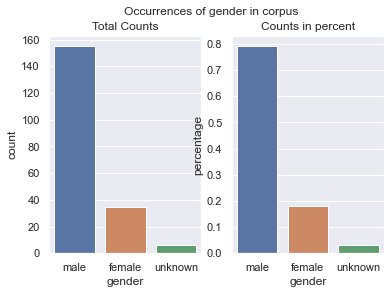

In [21]:
#bgrf_year_corpus = combined[combined["origin"]=="corpus"]["bgrf_year"].dt.year

print('Set of all occuring values:', set(combined[combined["origin"]=="corpus"]["gender"].values))
print("Percent of all genders in corpus \n",combined[combined["origin"]=="corpus"]["gender"].value_counts(normalize=True).round(3))
print("Counts of all genders in corpus \n",combined[combined["origin"]=="corpus"]["gender"].value_counts().round(3))
## Visualization in total counts:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("Occurrences of gender in corpus")
sns.countplot(x=combined[combined["origin"]=="corpus"]["gender"], 
              order=combined[combined["origin"]=="corpus"]["gender"].value_counts().index, ax=ax1)
sns.barplot(data=combined[combined["origin"]=="corpus"]["gender"].value_counts(normalize=True).round(3).reset_index().rename(columns={"index":"gender", "gender":"percentage"}).sort_values(by="percentage", ascending=False),
             x="gender", y="percentage", ax=ax2)
ax1.set_title('Total Counts')
ax2.set_title('Counts in percent')

### Author Gender (Wikibase)


    gender    per
0     male  0.577
1  unknown  0.290
2   female  0.134


Text(0, 0.5, 'Percent in wikidata')

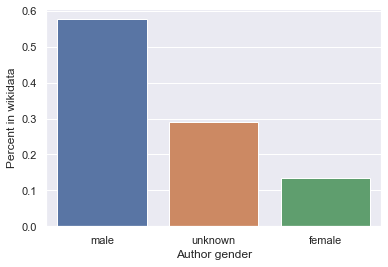

In [22]:
wikibase_gender_per = wikibase_data["gender"].value_counts(normalize=True).round(3).reset_index()
wikibase_gender_per.columns = ["gender", "per"]

print(wikibase_gender_per)
sns.barplot(data=wikibase_gender_per, x="gender", y="per")
plt.xlabel('Author gender')
plt.ylabel('Percent in wikidata')


### Comparison

#### Comparison of gender proportion in corpus and in wikibase


Text(0, 0.5, 'proportion')

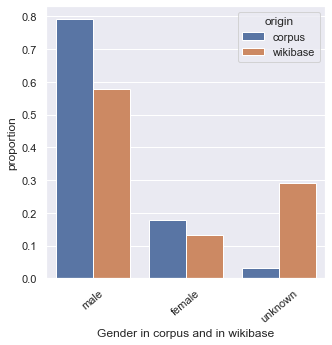

In [23]:

authors_grouped = combined.groupby(["origin"])["gender"].value_counts(normalize=True).reset_index(name="percentage")

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.barplot(x="gender", y="percentage", hue="origin", data=authors_grouped)
plt.xticks(rotation=40)
plt.xlabel("Gender in corpus and in wikibase")
plt.ylabel("proportion")

We can see that the "unknown" annotated genders in the wikibase is quite high; that results of many authors that do not have a prename or a title like "comte" or "comtesse" which we covered in the previous part.
So for a "better" comparison we could remove all unknown gender data. This we will do in the following part where the genders will be compared within the decades.

#### Comparison by decades

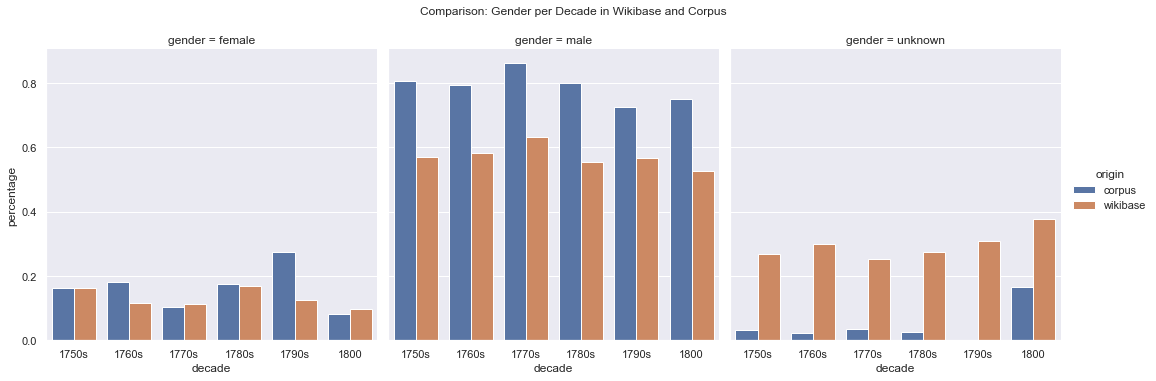

In [24]:
authors_decades = combined[["origin", "decade", "gender"]].groupby(["origin", "decade"]).value_counts(normalize=True, sort=False).reset_index(name="percentage")

# plot the data
sns.catplot(x="decade", y="percentage", hue="origin", col="gender", data=authors_decades, kind="bar")
plt.suptitle("Comparison: Gender per Decade in Wikibase and Corpus", y=1.05)
fig.tight_layout()


As we can see, the "unknown" gender in the xml-tei-corpus is so small that it is not quite visible in the visualization. Also the gender in the wikibase is based on the gender-guesser who cannot map all of the authors' names (e.g. only surnames etc.).
So in the following visualization we will drop the "unknown".

Text(0.5, 1.05, 'Comparison: Gender per Decade in Wikibase and Corpus without unknown gender')

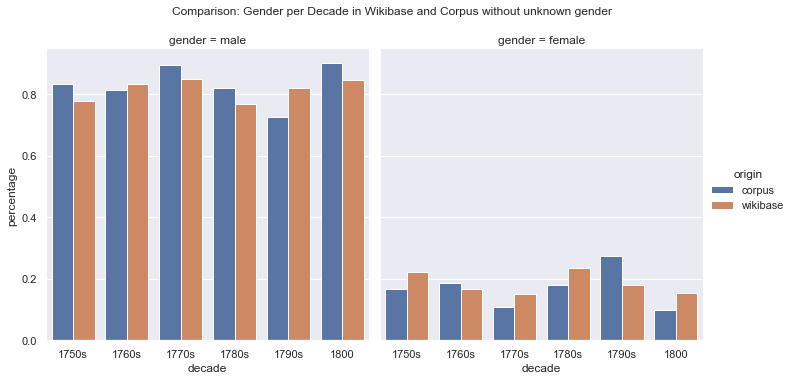

In [25]:
authors_wo_unknown = combined.drop(combined[(combined["gender"] == "unknown")].index)

authors_wo_unknown = authors_wo_unknown[["origin", "decade", "gender"]].groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")
sns.catplot(x="decade", y="percentage", hue="origin", col="gender", data=authors_wo_unknown, kind="bar")
plt.suptitle("Comparison: Gender per Decade in Wikibase and Corpus without unknown gender", y=1.05)

## Publication Date

### Corpus Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it. In case of year ranges, we simply use the first year.

If we run the cell below, we can check the first edition year and the bgrf numbers, where we will see that they differ a little bit, which can be caused by different sources of the first year information. Also there are few texts in the corpus that are not listed in the Bibliographie as novels, but we considered as interesting. For comparison though we will drop those now.

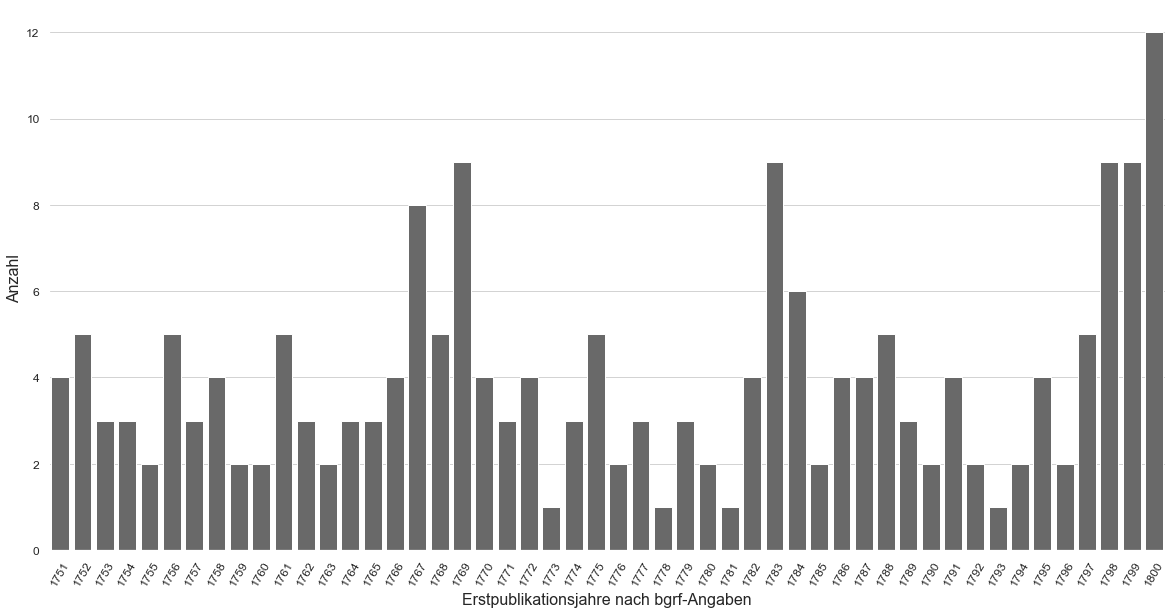

In [26]:
## Visualization of first year of publication in metadata

## Erstpublikation nach firsted-yr
firsted_corpus_sorted_yr = corpus["firsted-yr"].dt.year
firsted_corpus_sorted_yr = firsted_corpus_sorted_yr.drop(index=list(firsted_corpus_sorted_yr[firsted_corpus_sorted_yr=="nan"].index)).sort_values()

## Erstpublikation nach bgrf-Angabe in metadaten:
firsted_corpus_sorted_bgrf = corpus["bgrf_year"].dt.year.sort_values()
firsted_corpus_sorted_bgrf = firsted_corpus_sorted_bgrf.drop(index=list(firsted_corpus_sorted_bgrf[firsted_corpus_sorted_bgrf==1801].index)).sort_values()

def get_countplot_first_pub(df, col):

    fig, ax = plt.subplots(figsize=(20,10))

    sns.countplot(x=df, color="dimgrey")
    ax.set_facecolor(color="white")
    plt.xticks(rotation = 60, fontsize=12)
    plt.yticks(fontsize=12)
 
    plt.ylabel("Anzahl", fontsize=16)
    plt.grid(color="lightgrey", axis='y')

    if col == "bgrf":
        plt.xlabel("Erstpublikationsjahre nach bgrf-Angaben", fontsize=16)
    else:
        plt.xlabel("Erstpublikationsjahre nach firsted-yr", fontsize=16)
    #plt.savefig("Erstpublikationsjahre_grey.png", dpi=300)
#get_countplot_first_pub(firsted_corpus_sorted_yr, "first-yr")
get_countplot_first_pub(firsted_corpus_sorted_bgrf, "bgrf")

#### Visualization of publication year in corpus

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '1751'),
  Text(1, 0, '1752'),
  Text(2, 0, '1753'),
  Text(3, 0, '1754'),
  Text(4, 0, '1755'),
  Text(5, 0, '1756'),
  Text(6, 0, '1757'),
  Text(7, 0, '1758'),
  Text(8, 0, '1759'),
  Text(9, 0, '1760'),
  Text(10, 0, '1761'),
  Text(11, 0, '1762'),
  Text(12, 0, '1763'),
  Text(13, 0, '1764'),
  Text(14, 0, '1765'),
  Text(15, 0, '1766'),
  Text(16, 0, '1767'),
  Text(17, 0, '1768'),
  Text(18, 0, '1769'),
  Text(19, 0, '1770'),
  Text(20, 0, '1771'),
  Text(21, 0, '1772'),
  Text(22, 0, '1773'),
  Text(23, 0, '1774'),
  Text(24, 0, '1775'),
  Text(25, 0, '1776'),
  Text(26, 0, '1777'),
  Text(27, 0, '1778'),
  Text(28, 0, '1779'),
  Text(29, 0, '1780'),
  Text(30, 0, '1781'),
  Text(31, 0, '1782'),
  Text(32, 0, '1783'),
  Text(33, 0, '1784'),
  

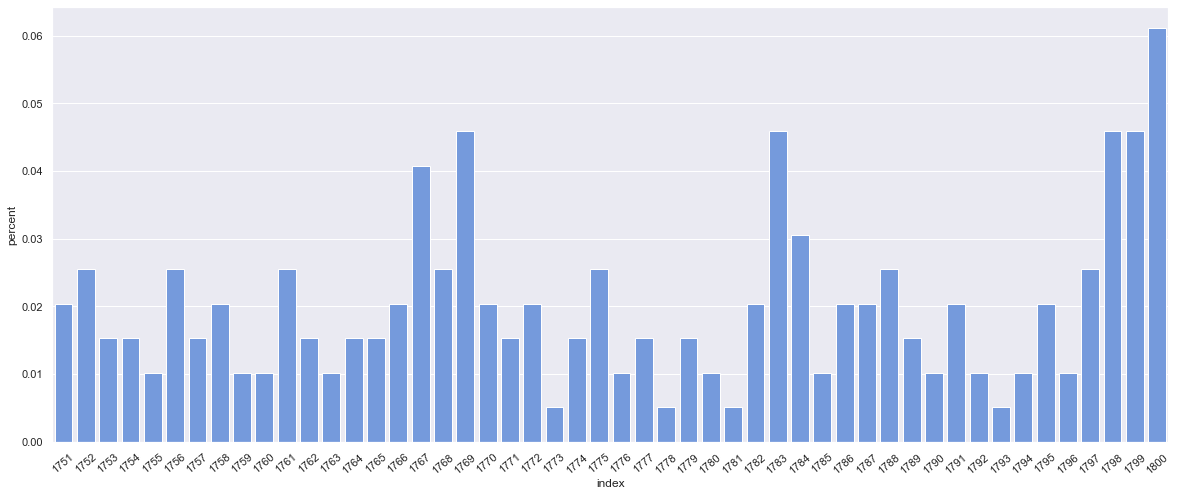

In [27]:
fig, ax = plt.subplots(figsize=(20,8))

bgrf_year_corpus = combined[combined["origin"]=="corpus"]["bgrf_year"].dt.year
bgrf_year_corpus = bgrf_year_corpus.value_counts(normalize=True).reset_index(name="percent")
sns.barplot(x=bgrf_year_corpus["index"], y=bgrf_year_corpus["percent"], color="cornflowerblue")
plt.xticks(rotation=40)


### Publication Date (Wikibase)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '1751'),
  Text(1, 0, '1752'),
  Text(2, 0, '1753'),
  Text(3, 0, '1754'),
  Text(4, 0, '1755'),
  Text(5, 0, '1756'),
  Text(6, 0, '1757'),
  Text(7, 0, '1758'),
  Text(8, 0, '1759'),
  Text(9, 0, '1760'),
  Text(10, 0, '1761'),
  Text(11, 0, '1762'),
  Text(12, 0, '1763'),
  Text(13, 0, '1764'),
  Text(14, 0, '1765'),
  Text(15, 0, '1766'),
  Text(16, 0, '1767'),
  Text(17, 0, '1768'),
  Text(18, 0, '1769'),
  Text(19, 0, '1770'),
  Text(20, 0, '1771'),
  Text(21, 0, '1772'),
  Text(22, 0, '1773'),
  Text(23, 0, '1774'),
  Text(24, 0, '1775'),
  Text(25, 0, '1776'),
  Text(26, 0, '1777'),
  Text(27, 0, '1778'),
  Text(28, 0, '1779'),
  Text(29, 0, '1780'),
  Text(30, 0, '1781'),
  Text(31, 0, '1782'),
  Text(32, 0, '1783'),
  Text(33, 0, '1784'),
  

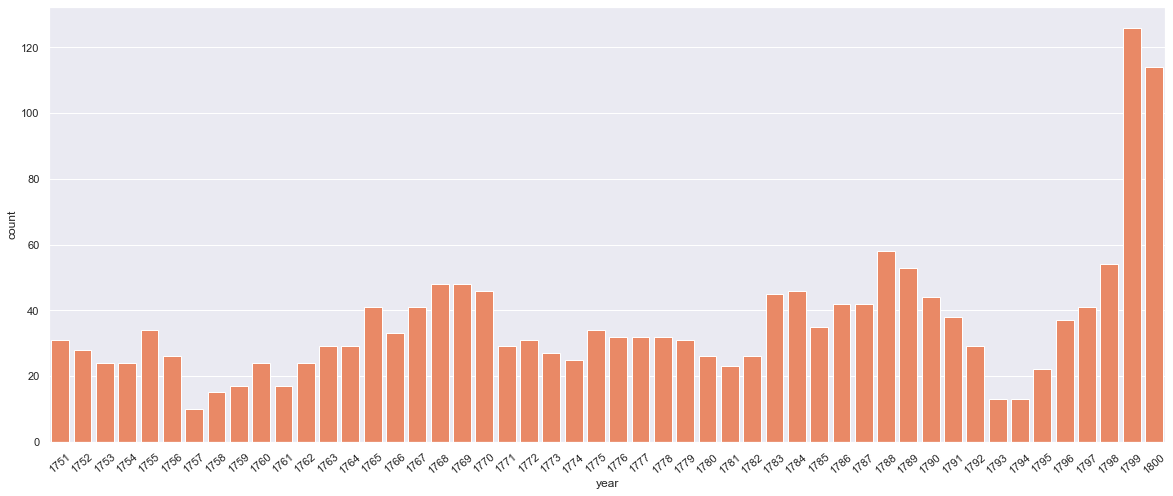

In [28]:
# Publication date
fig, ax = plt.subplots(figsize=(20,8))
plot = sns.countplot(x=combined[combined["origin"] == "wikibase"]["year"].dt.year, color="coral")
plt.xticks(rotation=40)


### Comparison Publication Date

In [29]:
# Publication year of corpus texts:
year_corpus = combined[combined["origin"] == "corpus"]['firsted-yr']
# Publication year of BGRF items:
year_wikibase = combined[combined["origin"] == "French novels"]['year']

# Create a date index which includes the whole data range
# so that we can fill in missing data points.
idx = pd.date_range(start='1751', end='1800', freq='YS', closed=None)

# In previous visualizations we have used absolute value counts.
# For comparison we obviously need to use relative frequencies instead.
df = pd.DataFrame(index=idx)
df['freq_corpus'] = year_corpus.value_counts(normalize=True)
print(df)
df['freq_bgrf'] = year_wikibase.value_counts(normalize=True)
df['year'] = df.index.year
print('The data in "wide form"\n', df.head(4), '\n')

# For the visualization we need the data in "long form", i.e. all the
# relative frequencies are in one single column, with another column 
# specifying whether it stems from the corpus or the bibliography.
long = pd.melt(
    df, id_vars=['year'], value_vars=['freq_corpus', 'freq_bgrf'],
    var_name='origin', value_name='rel_freq')

print('The data in "long form"\n', long.head(4))

            freq_corpus
1751-01-01     0.025510
1752-01-01     0.025510
1753-01-01     0.015306
1754-01-01     0.010204
1755-01-01     0.015306
1756-01-01     0.025510
1757-01-01     0.015306
1758-01-01     0.025510
1759-01-01     0.010204
1760-01-01     0.015306
1761-01-01     0.025510
1762-01-01     0.010204
1763-01-01     0.010204
1764-01-01     0.020408
1765-01-01     0.015306
1766-01-01     0.020408
1767-01-01     0.040816
1768-01-01     0.025510
1769-01-01     0.045918
1770-01-01     0.020408
1771-01-01     0.015306
1772-01-01     0.020408
1773-01-01     0.005102
1774-01-01     0.015306
1775-01-01     0.025510
1776-01-01     0.015306
1777-01-01     0.015306
1778-01-01     0.010204
1779-01-01     0.010204
1780-01-01     0.010204
1781-01-01     0.005102
1782-01-01     0.020408
1783-01-01     0.030612
1784-01-01     0.025510
1785-01-01     0.010204
1786-01-01     0.015306
1787-01-01     0.025510
1788-01-01     0.025510
1789-01-01     0.010204
1790-01-01     0.015306
1791-01-01     0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_34536\1756004647.py:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  idx = pd.date_range(start='1751', end='1800', freq='YS', closed=None)


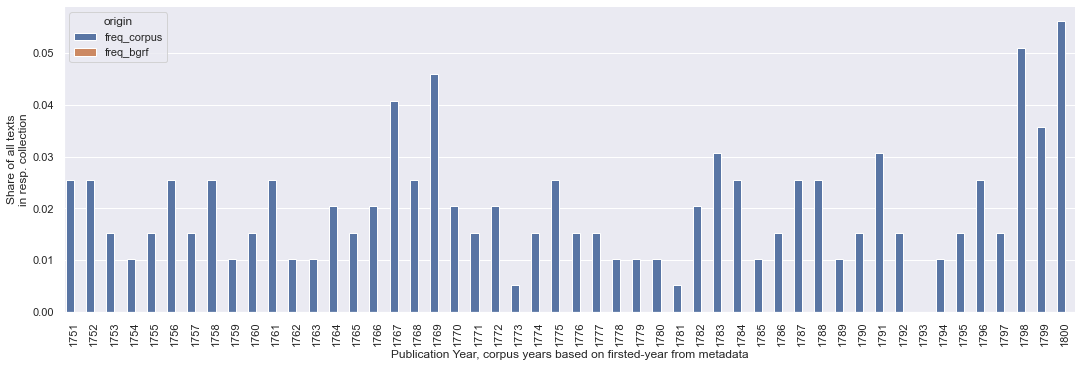

In [162]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long[long['year'] > 1750], height=5, aspect=3,
           legend_out=False)
plt.xlabel('Publication Year, corpus years based on firsted-year from metadata')
plt.ylabel('Share of all texts\nin resp. collection')
_ = plt.xticks(rotation=90)

Comparison of publication years based on year created on bgrf.

Text(0, 0.5, 'percent')

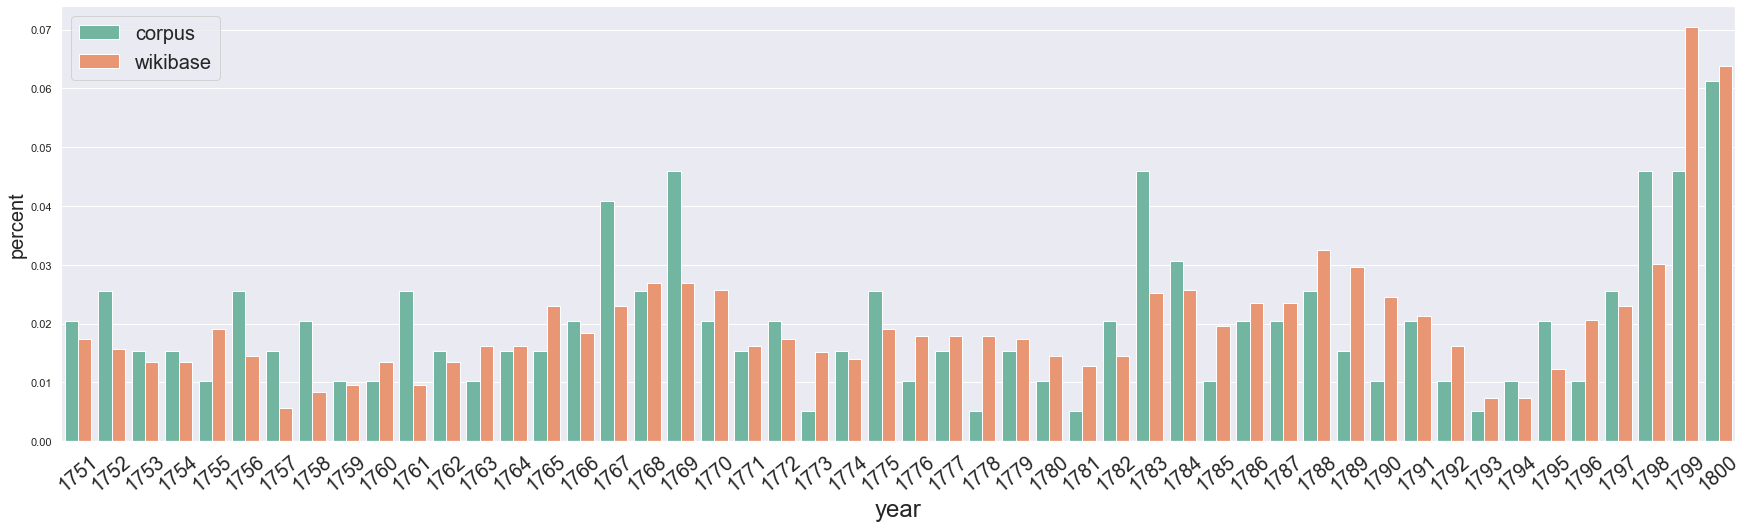

In [30]:
pubyears = combined[["origin", "year"]]
pubyears = pubyears.drop(pubyears[pubyears["year"] == 1801].index)
pubyears_grouped = pubyears.groupby(["origin"]).value_counts(normalize=True).reset_index(name="percentage")

# sort for years for visualization
years = sorted(set(pubyears["year"].dt.year))
fig, ax = plt.subplots(figsize=(30,8))
ax = sns.barplot(x=pubyears_grouped["year"].dt.year, y=pubyears_grouped["percentage"], hue="origin", data=pubyears_grouped, order = years, palette ='Set2')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.legend(fontsize=20)
plt.xticks(rotation=40)
plt.xlabel("year", fontsize=24)
plt.ylabel("percent", fontsize=20)

Text(0, 0.5, 'percent')

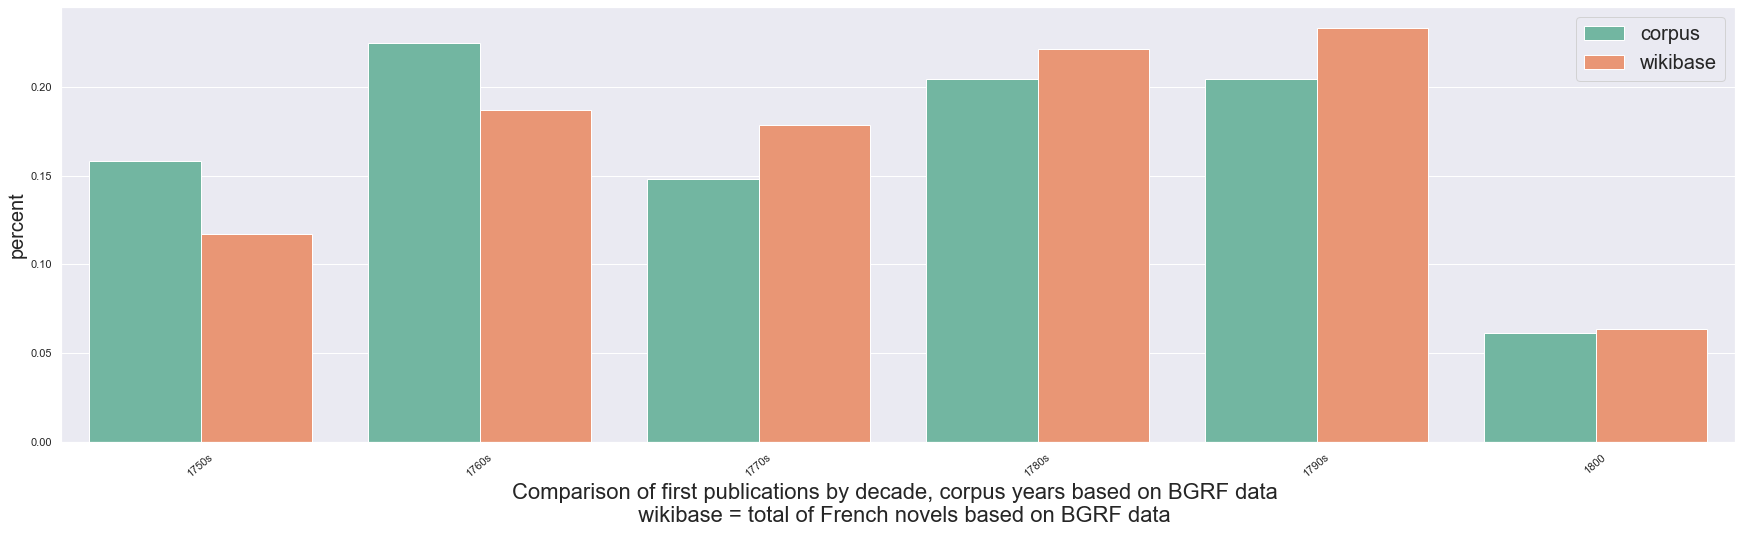

In [31]:
pubyears = combined[["origin", "decade"]]
#pubyears = pubyears.drop(pubyears[pubyears["year"] == 1801].index)
pubyears_grouped = pubyears.groupby(["origin"]).value_counts(normalize=True).reset_index(name="percentage")

# sort for years for visualization
decade = sorted(set(pubyears["decade"]))
fig, ax = plt.subplots(figsize=(30,8))


ax = sns.barplot(x=pubyears_grouped["decade"], y=pubyears_grouped["percentage"], hue="origin", data=pubyears_grouped, order = decade, palette ='Set2')
ax.legend(fontsize=20)
    
plt.xticks(rotation=40)
plt.xlabel("Comparison of first publications by decade, corpus years based on BGRF data \n  wikibase = total of French novels based on BGRF data", fontsize=22)
plt.ylabel("percent", fontsize=20)

Text(0, 0.5, 'percent')

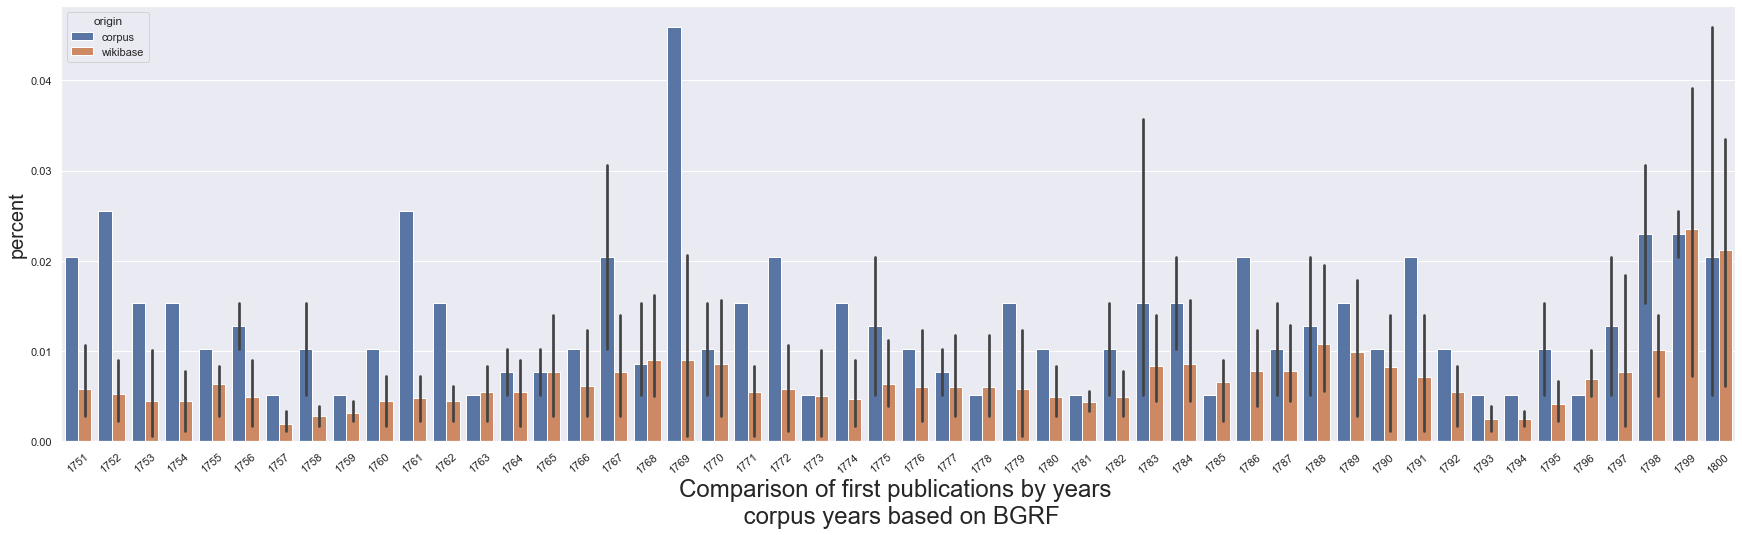

In [32]:
pubyears = combined[["origin", "year", "gender"]]
pubyears = pubyears.drop(pubyears[pubyears["year"] == 1801].index)
pubyears_grouped = pubyears.groupby(["origin"]).value_counts(normalize=True).reset_index(name="percentage")

# sort for years for visualization
years = sorted(set(pubyears["year"].dt.year))
fig, ax = plt.subplots(figsize=(30,8))
ax = sns.barplot(x=pubyears_grouped["year"].dt.year, y=pubyears_grouped["percentage"], hue="origin", data=pubyears_grouped, order = years)
plt.xticks(rotation=40)
plt.xlabel("Comparison of first publications by years \n corpus years based on BGRF", fontsize=24)
plt.ylabel("percent", fontsize=20)

## Narrative Form

### Narrative form corpus
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {'homodiegetic', 'dialogue novel', 'epistolary', 'unknown', 'mixed', 'heterodiegetic', 'autodiegetic'}
% of mixed: 	0.046
% of autodiegetic: 	0.260
% of heterodiegetic: 	0.439
% of homodiegetic: 	0.026
% of epistolary: 	0.194
% of dialogue novel: 	0.031


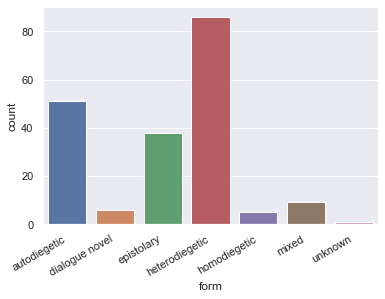

In [33]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
plot = sns.countplot(x=form)
_ = plt.xticks(rotation=30, horizontalalignment='right')

### Narrative Form (Wikibase)

In the wikibase data some of the narrative forms are written a little different like dialogue novel vs. dialugue. In order to compare both the Wikibase-Data and the Metadata we will have to align those.

In [34]:
combined["form"] = combined["form"].map(lambda x: "dialogue novel" if x == "dialogue" else x)
print(combined.groupby(["origin", "form"])["form"].count())

origin    form          
corpus    autodiegetic       51
          dialogue novel      6
          epistolary         38
          heterodiegetic     86
          homodiegetic        5
          mixed               9
          unknown             1
wikibase  autodiegetic      402
          dialogue novel     13
          epistolary        204
          heterodiegetic    643
          homodiegetic       13
          mixed              62
          unknown           452
Name: form, dtype: int64


Plot narrative forms from Wikibase.

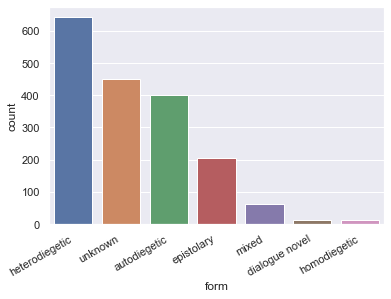

In [35]:
narrform_bgrf = combined[combined["origin"] == "wikibase"]["form"].reset_index()
plot = sns.countplot(x=narrform_bgrf['form'])
_ = plt.xticks(rotation=30, horizontalalignment='right')

## Comparison

### Narrative Form (Corpus vs BGRF)

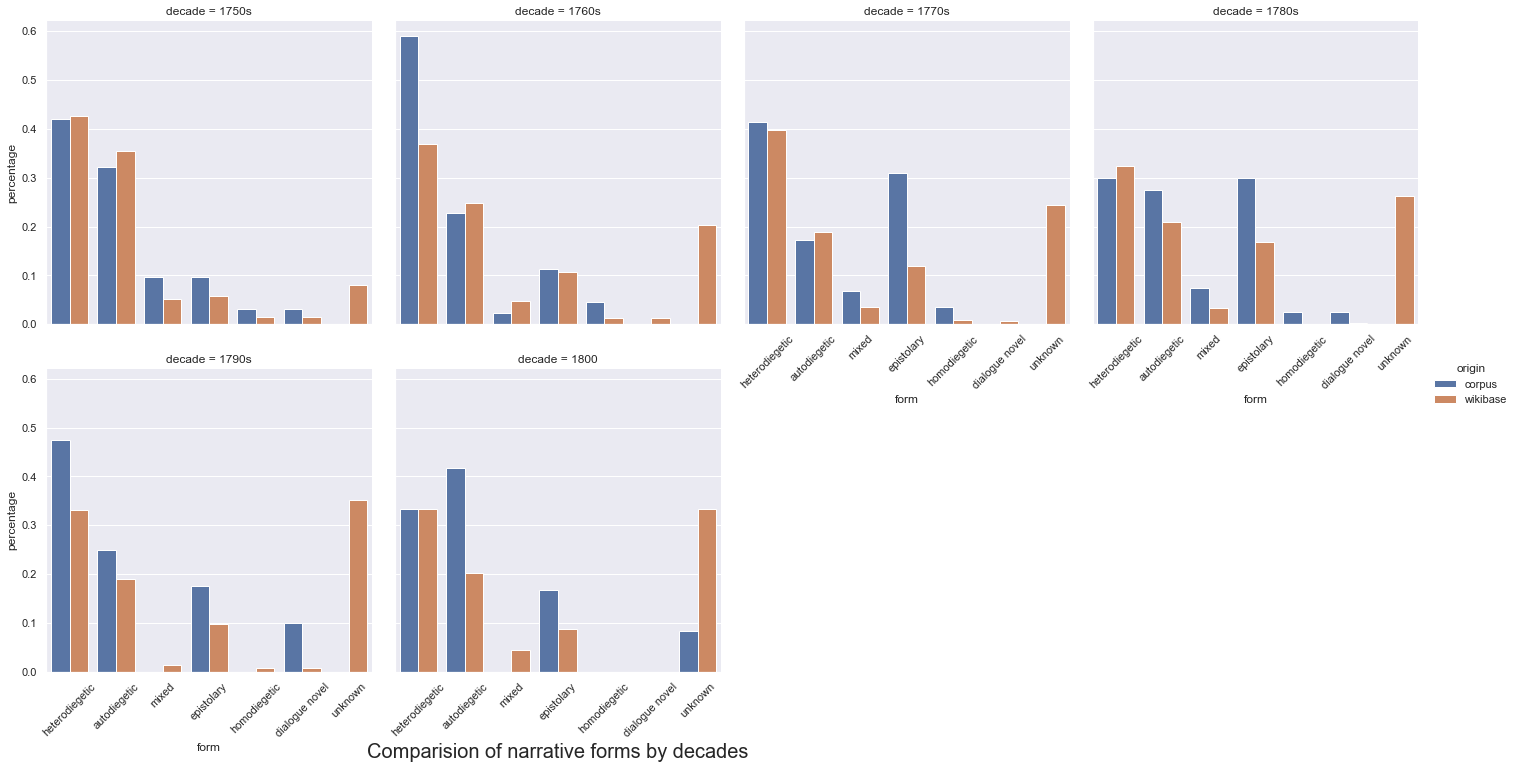

In [36]:
## comparison of the narrative forms by decade

narr_form_grouped = combined[["origin", "decade", "form"]].groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin", col_wrap=4, data=narr_form_grouped, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparision of narrative forms by decades", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

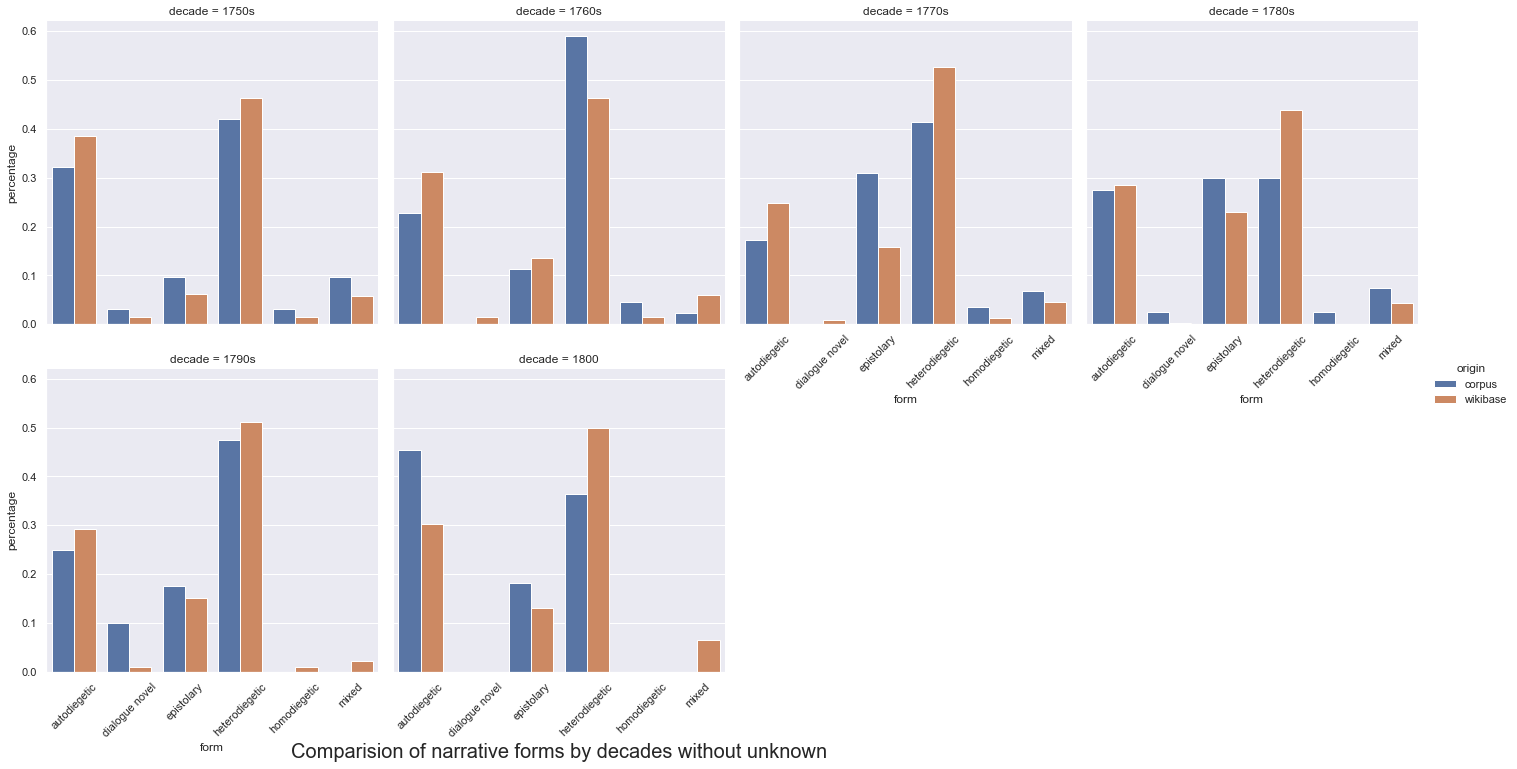

In [37]:
## drop unknown:
narr_form_combined = combined[["form", "decade", "origin"]]
narr_form_combined_wo_unknown = narr_form_combined.drop(narr_form_combined[(narr_form_combined["form"] == "unknown")].index)

narr_form_grouped_wo_unknwon = narr_form_combined_wo_unknown[["origin", "decade", "form"]].groupby(["origin", "decade"]).value_counts(normalize=True, sort=False).reset_index(name="percentage")

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin",col_wrap=4, data=narr_form_grouped_wo_unknwon, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparision of narrative forms by decades without unknown", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

Narrative forms by gender in corpus

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'autodiegetic'),
  Text(1, 0, 'dialogue novel'),
  Text(2, 0, 'epistolary'),
  Text(3, 0, 'heterodiegetic'),
  Text(4, 0, 'homodiegetic'),
  Text(5, 0, 'mixed'),
  Text(6, 0, 'unknown')])

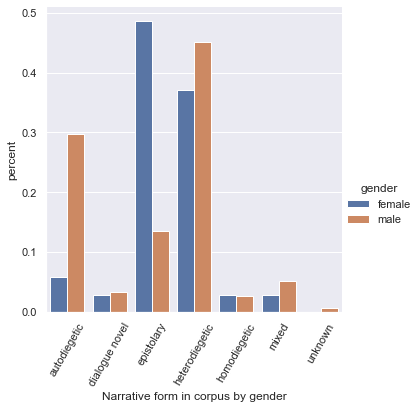

In [38]:
authors_narr_grouped = combined[combined["origin"] == "corpus"][["form", "gender"]]

authors_narr_grouped = authors_narr_grouped.drop(authors_narr_grouped[(authors_narr_grouped["gender"] == "unknown")].index)

authors_narr_grouped = authors_narr_grouped.groupby(["gender"]).value_counts(normalize=True, sort=False).reset_index(name="percent")


ax = sns.catplot(x="form", y="percent",  hue="gender", data=authors_narr_grouped, kind="bar")
plt.xlabel("Narrative form in corpus by gender")
plt.xticks(rotation=60)

Narrative forms by gender in wikibase

    gender            form   percent
0   female  heterodiegetic  0.380753
1   female      epistolary  0.242678
2   female         unknown  0.217573
3   female    autodiegetic  0.104603
4   female           mixed  0.041841
5   female    homodiegetic  0.008368
6   female  dialogue novel  0.004184
7     male  heterodiegetic  0.369186
8     male         unknown  0.261628
9     male    autodiegetic  0.228682
10    male      epistolary  0.095930
11    male           mixed  0.029070
12    male  dialogue novel  0.008721
13    male    homodiegetic  0.006783


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'heterodiegetic'),
  Text(1, 0, 'epistolary'),
  Text(2, 0, 'unknown'),
  Text(3, 0, 'autodiegetic'),
  Text(4, 0, 'mixed'),
  Text(5, 0, 'homodiegetic'),
  Text(6, 0, 'dialogue novel')])

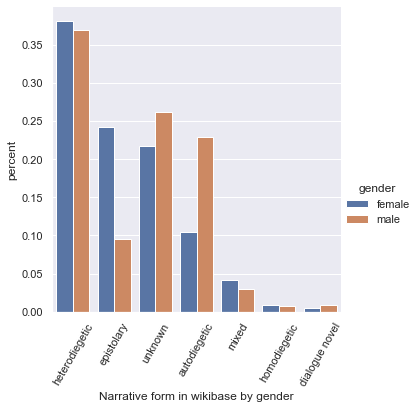

In [39]:
authors_narr_grouped_w = combined[combined["origin"] == "wikibase"][["form", "gender"]]

authors_narr_grouped_w = authors_narr_grouped_w.drop(authors_narr_grouped_w[(authors_narr_grouped_w["gender"] == "unknown")].index)

authors_narr_grouped_w = authors_narr_grouped_w.groupby(["gender"]).value_counts(normalize=True).reset_index(name="percent")
print(authors_narr_grouped_w)

ax = sns.catplot(x="form", y="percent",  hue="gender", data=authors_narr_grouped_w, kind="bar")
plt.xlabel("Narrative form in wikibase by gender")
plt.xticks(rotation=60)

### Narrative Form: Author gender wikibase and corpus comparison

Text(0.5, 0.98, 'Narrative form in corpus and wikibase by gender')

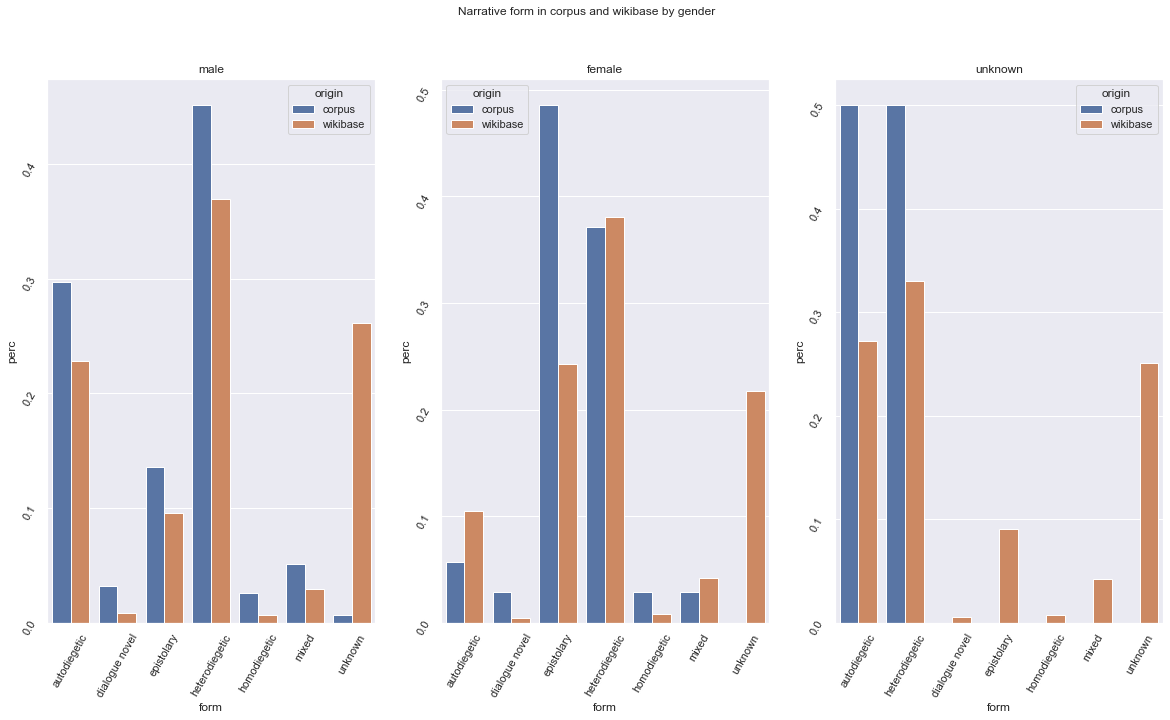

In [40]:
authors_gender_narr = combined[["gender", "origin", "form"]]
authors_gender_narr_grouped = authors_gender_narr[["origin", "form", "gender"]].groupby(["origin", "gender"]).value_counts(normalize=True, sort=False).reset_index(name="perc")

fig, axes = plt.subplots(1,3, figsize=(20,10))
ax1 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "male"], ax=axes[0])
axes[0].set_title("male")
ax2 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "female"], ax=axes[1])
axes[1].set_title("female")
ax3 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "unknown"], ax=axes[2])
axes[2].set_title("unknown")
#axes.xlabel("Narrative form in corpus and wikibase by gender")
for ax in fig.axes:
    ax.tick_params(rotation=60)
fig.suptitle("Narrative form in corpus and wikibase by gender")

Same plot, but without the unknown gender.

      gender    origin            form
0       male    corpus      epistolary
1       male    corpus  heterodiegetic
2       male    corpus  heterodiegetic
3       male    corpus  heterodiegetic
4       male    corpus    autodiegetic
...      ...       ...             ...
1980  female  wikibase  heterodiegetic
1981  female  wikibase  heterodiegetic
1982    male  wikibase  heterodiegetic
1983  female  wikibase      epistolary
1984    male  wikibase  heterodiegetic

[1461 rows x 3 columns]


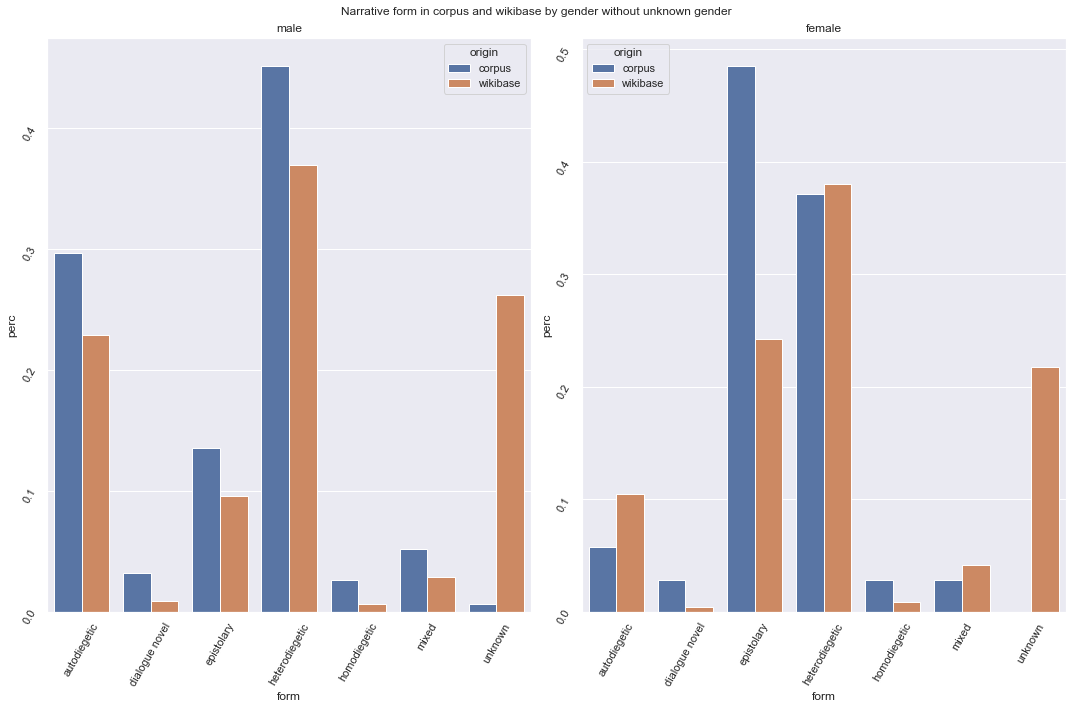

In [41]:
authors_gender_narr_without_unknown = authors_gender_narr[authors_gender_narr["gender"] != "unknown"]
print(authors_gender_narr_without_unknown)
authors_gender_narr_without_unknown = authors_gender_narr_without_unknown[["origin", "form", "gender"]].groupby(["origin", "gender"]).value_counts(normalize=True, sort=False).reset_index(name="perc")
#print(authors_gender_narr_without_unknwon_grouped)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
ax1 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_without_unknown[authors_gender_narr_without_unknown["gender"] == "male"], ax=axes[0])
axes[0].set_title("male")
ax2 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_without_unknown[authors_gender_narr_without_unknown["gender"] == "female"], ax=axes[1])
axes[1].set_title("female")

for ax in fig.axes:
    ax.tick_params(rotation=60)
fig.suptitle("Narrative form in corpus and wikibase by gender without unknown gender")
plt.tight_layout()

### Further comparisons

Now let's do some futher comparisons. These will be used internally to check how balanced the corpus is. Therefore we will copy the dataframe once more and drop items that "empty" cells.

In [42]:
wikib = combined[combined["origin"] == "wikibase"][["form", "gender", "decade"]].copy()

wikib = wikib.dropna()

In [43]:
wikib = wikib.groupby(["decade","form", "gender"], dropna=False).value_counts().reset_index(name="counts_wikib")
print(wikib["counts_wikib"].sum())
wikib["anteil_wikibase"] = wikib.apply(lambda x: x.counts_wikib / wikib["counts_wikib"].sum(), axis=1)
wikib = wikib.rename(columns={"dialogue novel": "dialog"})
print(wikib)

1789
    decade            form   gender  counts_wikib  anteil_wikibase
0    1750s    autodiegetic   female             4         0.002236
1    1750s    autodiegetic     male            43         0.024036
2    1750s    autodiegetic  unknown            27         0.015092
3    1750s  dialogue novel   female             1         0.000559
4    1750s  dialogue novel     male             1         0.000559
..     ...             ...      ...           ...              ...
99    1800           mixed   female             2         0.001118
100   1800           mixed     male             1         0.000559
101   1800           mixed  unknown             2         0.001118
102   1800         unknown     male            19         0.010620
103   1800         unknown  unknown            19         0.010620

[104 rows x 5 columns]


In [44]:
meta = combined[combined["origin"] == "corpus"][["form", "gender", "decade"]].copy()
print("meta: ", len(meta), meta.columns.to_list())

meta = meta.dropna()
print(len(meta))

meta:  196 ['form', 'gender', 'decade']
196


In [45]:
meta = meta.groupby(["decade", "form", "gender"], dropna=False).value_counts().reset_index(name="counts_meta")
print(meta["counts_meta"].sum())
print(meta.head())

196
  decade            form  gender  counts_meta
0  1750s    autodiegetic    male           10
1  1750s  dialogue novel    male            1
2  1750s      epistolary  female            2
3  1750s      epistolary    male            1
4  1750s  heterodiegetic  female            3


In [46]:
meta["anteil_corpus"] = meta.apply(lambda x: x.counts_meta / meta["counts_meta"].sum(), axis=1)

In [47]:
result = pd.merge(wikib, meta, how="outer", on=["form", "gender", "decade"]).fillna(0)
result

,decade,form,gender,counts_wikib,anteil_wikibase,counts_meta,anteil_corpus
0,1750s,autodiegetic,female,4.0,0.002236,0.0,0.000000
1,1750s,autodiegetic,male,43.0,0.024036,10.0,0.051020
2,1750s,autodiegetic,unknown,27.0,0.015092,0.0,0.000000
3,1750s,dialogue novel,female,1.0,0.000559,0.0,0.000000
4,1750s,dialogue novel,male,1.0,0.000559,1.0,0.005102
...,...,...,...,...,...,...,...
101,1800,mixed,unknown,2.0,0.001118,0.0,0.000000
102,1800,unknown,male,19.0,0.010620,1.0,0.005102
103,1800,unknown,unknown,19.0,0.010620,0.0,0.000000
104,1780s,dialogue novel,female,0.0,0.000000,1.0,0.005102


In [48]:
result["result"] = result.apply(lambda x: "too few" if x.anteil_wikibase > x.anteil_corpus else "too many", axis=1)

In [49]:
resulttest = result.copy()
combined_t = combined.copy()
resulttest

,decade,form,gender,counts_wikib,anteil_wikibase,counts_meta,anteil_corpus,result
0,1750s,autodiegetic,female,4.0,0.002236,0.0,0.000000,too few
1,1750s,autodiegetic,male,43.0,0.024036,10.0,0.051020,too many
2,1750s,autodiegetic,unknown,27.0,0.015092,0.0,0.000000,too few
3,1750s,dialogue novel,female,1.0,0.000559,0.0,0.000000,too few
4,1750s,dialogue novel,male,1.0,0.000559,1.0,0.005102,too many
...,...,...,...,...,...,...,...,...
101,1800,mixed,unknown,2.0,0.001118,0.0,0.000000,too few
102,1800,unknown,male,19.0,0.010620,1.0,0.005102,too few
103,1800,unknown,unknown,19.0,0.010620,0.0,0.000000,too few
104,1780s,dialogue novel,female,0.0,0.000000,1.0,0.005102,too many


wikitest 
                       anteil_wikibase          
gender                         female      male
decade form                                    
1750s  autodiegetic          0.002236  0.024036
       dialogue novel        0.000559  0.000559
       epistolary            0.002236  0.003913
       heterodiegetic        0.012297  0.027390
       homodiegetic          0.000000  0.000559
       mixed                 0.000000  0.003913
       unknown               0.001677  0.006149
1760s  autodiegetic          0.003913  0.026272
       dialogue novel        0.000000  0.001677
       epistolary            0.005590  0.008944
       heterodiegetic        0.006708  0.041923
       homodiegetic          0.001118  0.000559
       mixed                 0.001118  0.004472
       unknown               0.003354  0.025154
1770s  autodiegetic          0.001118  0.020682
       dialogue novel        0.000000  0.001118
       epistolary            0.005031  0.010620
       heterodiegetic        

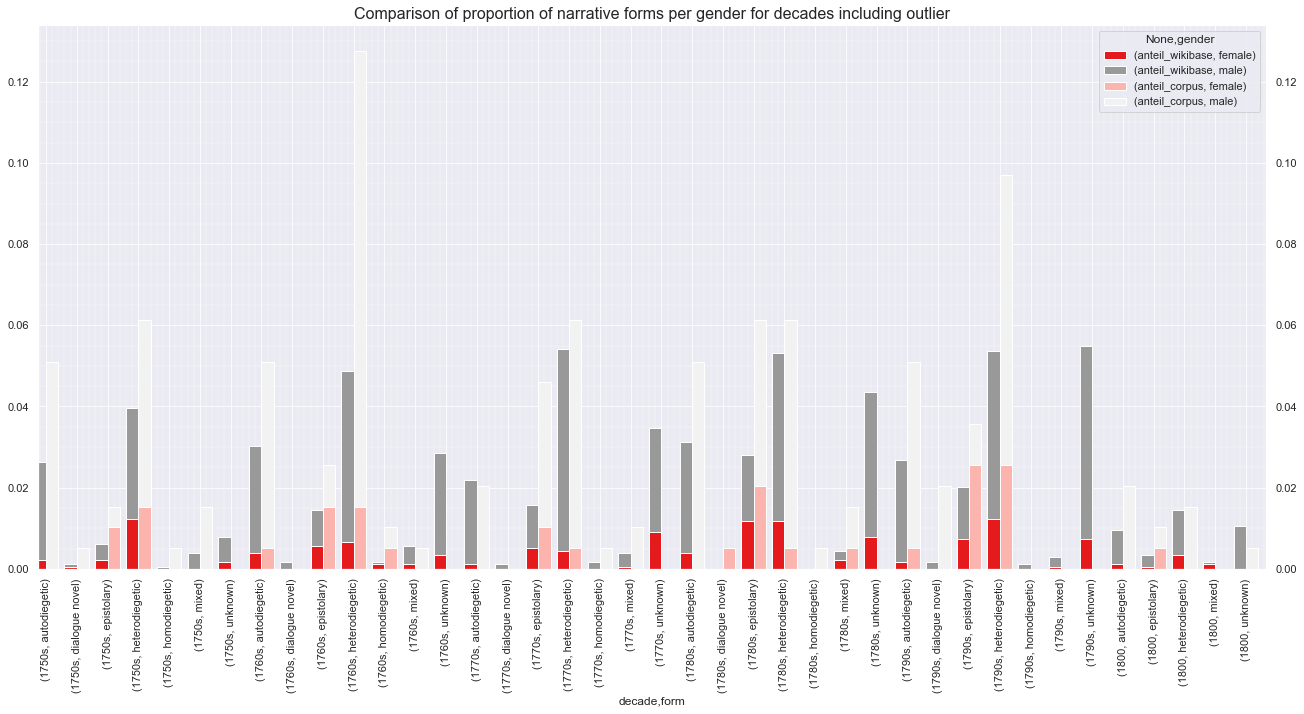

In [51]:
def plot_balancing_years(resulttest, how):
    genders = ["male", "female", "unknown"]
    forms = resulttest["form"].unique()

    resulttest = resulttest.drop(columns=["result", "counts_meta"])
    resulttest = resulttest[resulttest.gender != "unknown"]

    if how == "outlier_data":
        ## as there are many novels in the wikibase that have only one match for the combination of gender, form and decade, we will drop those
        wikitest = resulttest.copy()
        wikitest["anteil_wikibase"] = wikitest.apply(lambda x: x["anteil_wikibase"] if x["counts_wikib"] > 1 else 0, axis=1)
        wikitest = wikitest.drop(columns=["counts_wikib"])
    elif how == "all_data":
        ## use all_data if you want to visualize all data, including the outliers
        wikitest = resulttest.drop(columns=["counts_wikib"])

    wikitest = wikitest.drop(columns=["anteil_corpus"])
    wikitest = wikitest.pivot_table(index=["decade","form"], columns=["gender"], fill_value=0)
    print("wikitest", "\n", wikitest)
    corpusresulttest = resulttest.drop(columns=["anteil_wikibase", "counts_wikib"])
    corpusresulttest = corpusresulttest.pivot_table(index=["decade","form"], columns=["gender"], fill_value=0)
    print("corpusresulttest", "\n", corpusresulttest)

    # plotting
    fig, ax = plt.subplots(figsize=(22,10))
    ax.grid(which="major", linewidth=0.8)
    ax.grid(which="minor", linewidth=0.3)
    ax.minorticks_on()
    
    wikitest.plot.bar(stacked=True, position=1, width=0.4, ax= ax, colormap="Set1")
    ax.tick_params(labelright=True)

    ax1 = corpusresulttest.plot.bar(stacked=True, ax=ax, position=0, width=0.4, colormap="Pastel1")
    if how == "all_data":
        plt.title("Comparison of proportion of narrative forms per gender for decades including outlier", fontsize=16)
    else:
        plt.title("Comparison of proportion of narrative forms per gender for decades without outlier", fontsize=16)

decades = combined_t["decade"].unique()
how = ["all_data", "outlier_data"]
plot_balancing_years(resulttest, how[0])

wikitest 
        anteil_wikibase          
gender          female      male
decade                          
1750s         0.003801  0.009503
1760s         0.003633  0.015571
1770s         0.004025  0.016130
1780s         0.006242  0.020496
1790s         0.005813  0.018845
1800          0.001537  0.006708
corpusresulttest 
        anteil_corpus          
gender        female      male
decade                        
1750s       0.005102  0.018222
1760s       0.006803  0.025510
1770s       0.003061  0.018222
1780s       0.005952  0.027211
1790s       0.011224  0.021137
1800        0.001276  0.009184


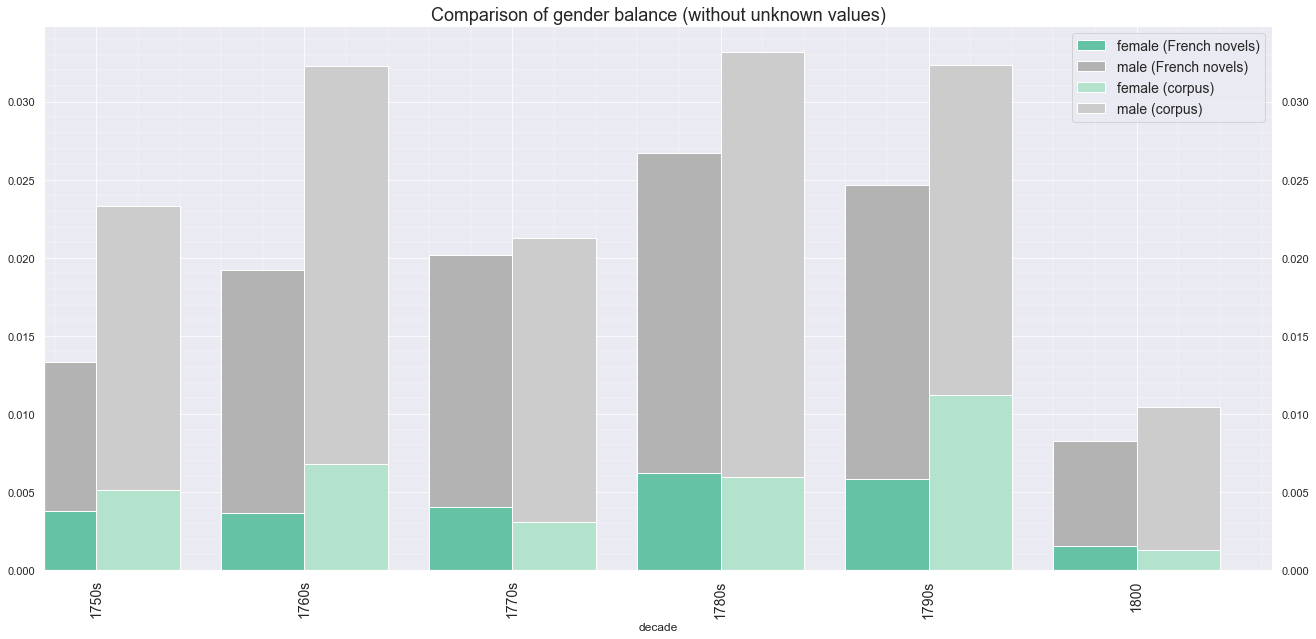

In [52]:
def plot_balancing_years(resulttest, how):
    genders = ["male", "female", "unknown"]
    forms = resulttest["form"].unique()

    resulttest = resulttest.drop(columns=["result", "counts_meta"])
    resulttest = resulttest[resulttest.gender != "unknown"]

    if how == "outlier_data":
        ## as there are many novels in the wikibase that have only one match for the combination of gender, form and decade, we will drop those
        wikitest = resulttest.copy()
        wikitest["anteil_wikibase"] = wikitest.apply(lambda x: x["anteil_wikibase"] if x["counts_wikib"] > 1 else 0, axis=1)
        wikitest = wikitest.drop(columns=["counts_wikib"])
    elif how == "all_data":
        ## use all_data if you want to visualize all data, including the outliers
        wikitest = resulttest.drop(columns=["counts_wikib"])

    wikitest = wikitest.drop(columns=["anteil_corpus"])
    wikitest = wikitest.pivot_table(index=["decade"], columns=["gender"], fill_value=0)
    print("wikitest", "\n", wikitest)
    corpusresulttest = resulttest.drop(columns=["anteil_wikibase", "counts_wikib"])
    corpusresulttest = corpusresulttest.pivot_table(index=["decade"], columns=["gender"], fill_value=0)
    print("corpusresulttest", "\n", corpusresulttest)

    # plotting
    fig, ax = plt.subplots(figsize=(22,10))
    ax.grid(which="major", linewidth=0.8)
    ax.grid(which="minor", linewidth=0.3)
    ax.minorticks_on()
    
    wikitest.plot.bar(stacked=True, position=1, width=0.4, ax= ax, colormap="Set2")
    ax.tick_params(labelright=True)
   # ax.legend(["female (MiMoTextBase)", "male (MiMoTextBase)", "unknown (MiMoTextBase)"]);

    ax1 = corpusresulttest.plot.bar(stacked=True, ax=ax, position=0, width=0.4, colormap="Pastel2")
    ax.legend(["female (French novels)", "male (French novels)", "female (corpus)", "male (corpus)"], fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    if how == "all_data":
        plt.title("Comparison of gender balance (without unknown values)", fontsize=18)
    else:
        plt.title("Comparison of gender balance (without unknown values)", fontsize=18)

decades = combined_t["decade"].unique()
how = ["all_data", "outlier_data"]
plot_balancing_years(resulttest, how[0])

wikitest 
        anteil_wikibase                                                        \
form      autodiegetic dialogue novel epistolary heterodiegetic homodiegetic   
decade                                                                         
1750s         0.013788       0.000000   0.002050       0.016583     0.000559   
1760s         0.015465       0.000838   0.006708       0.022918     0.000373   
1770s         0.011179       0.001118   0.007080       0.023663     0.001677   
1780s         0.015465       0.000000   0.012484       0.023849     0.000000   
1790s         0.014720       0.001677   0.007639       0.025713     0.000559   
1800          0.004285       0.000000   0.001677       0.007080     0.000000   

                  
form       mixed  
decade            
1750s   0.003074  
1760s   0.002981  
1770s   0.001863  
1780s   0.002422  
1790s   0.000745  
1800    0.000745  
corpusresulttest 
        anteil_corpus                                                        \


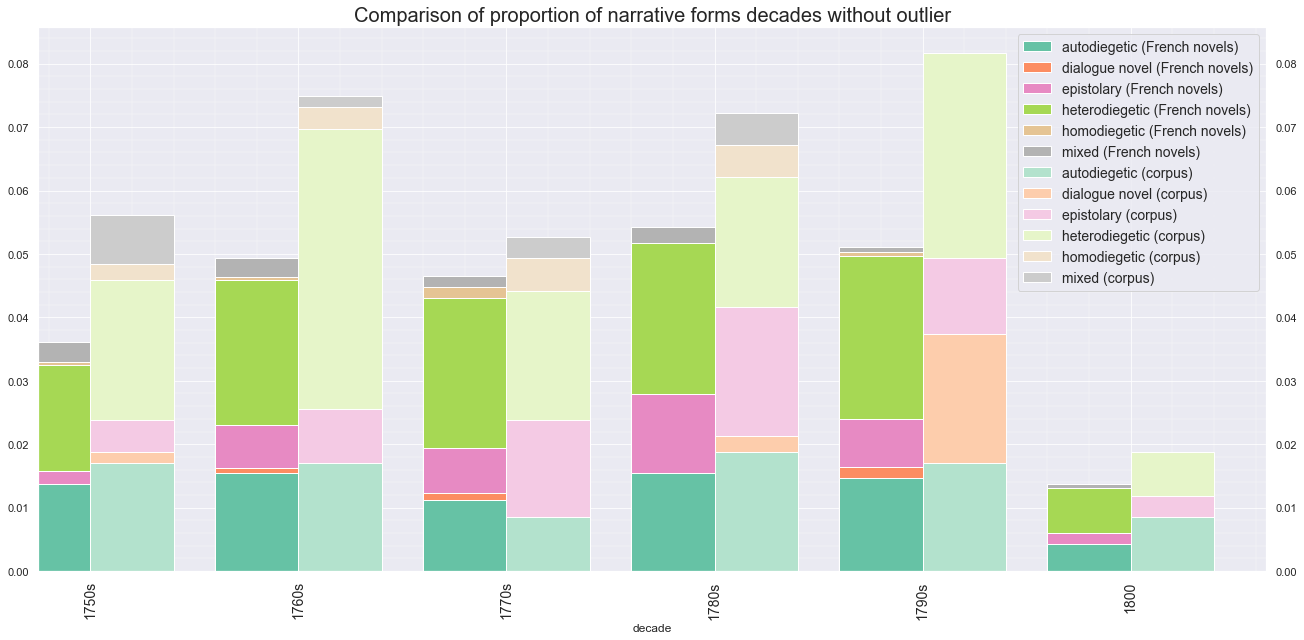

In [57]:
def plot_balancing_years(resulttest, how):
    genders = ["male", "female", "unknown"]
    forms = resulttest["form"].unique()

    resulttest = resulttest.drop(columns=["result", "counts_meta"])
    resulttest = resulttest[resulttest.form != "unknown"]

    if how == "outlier_data":
        ## as there are many novels in the wikibase that have only one match for the combination of gender, form and decade, we will drop those
        wikitest = resulttest.copy()
        wikitest["anteil_wikibase"] = wikitest.apply(lambda x: x["anteil_wikibase"] if x["counts_wikib"] > 1 else 0, axis=1)
        wikitest = wikitest.drop(columns=["counts_wikib"])
    elif how == "all_data":
        ## use all_data if you want to visualize all data, including the outliers
        wikitest = resulttest.drop(columns=["counts_wikib"])

    wikitest = wikitest.drop(columns=["anteil_corpus"])
    wikitest = wikitest.pivot_table(index=["decade"], columns=["form"], fill_value=0)
    print("wikitest", "\n", wikitest)
    corpusresulttest = resulttest.drop(columns=["anteil_wikibase", "counts_wikib"])
    corpusresulttest = corpusresulttest.pivot_table(index=["decade"], columns=["form"], fill_value=0)
    print("corpusresulttest", "\n", corpusresulttest)

    # plotting
    fig, ax = plt.subplots(figsize=(22,10))
    ax.grid(which="major", linewidth=0.8)
    ax.grid(which="minor", linewidth=0.3)
    ax.minorticks_on()
    
    wikitest.plot.bar(stacked=True, position=1, width=0.4, ax= ax, colormap="Set2")
    ax.tick_params(labelright=True)

    ax1 = corpusresulttest.plot.bar(stacked=True, ax=ax, position=0, width=0.4, colormap="Pastel2")
    ax.legend(["autodiegetic (French novels)", "dialogue novel (French novels)", "epistolary (French novels)", "heterodiegetic (French novels)", "homodiegetic (French novels)", "mixed (French novels)",
 "autodiegetic (corpus)", "dialogue novel (corpus)", "epistolary (corpus)", "heterodiegetic (corpus)", "homodiegetic (corpus)", "mixed (corpus)"], fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    if how == "all_data":
        plt.title("Comparison of proportion of narrative forms per decades including outlier", fontsize=20)
    else:
        plt.title("Comparison of proportion of narrative forms decades without outlier", fontsize=20)
    
    plt.savefig("Comparison_narr_forms_per_decade.tiff", dpi=300, transparent=False)

decades = combined_t["decade"].unique()
how = ["all_data", "outlier_data"]
plot_balancing_years(resulttest, how[1])